In [ ]:
#!pip install -q sentence-transformers
#!pip install --upgrade xgboost
#!pip install openai azure-core
#!pip install scispacy
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_ner_bc5cdr_md-0.4.0.tar.gz
#!pip install openai faiss-cpu tqdm


## Import list:

In [ ]:
from sentence_transformers import SentenceTransformer
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sentence_transformers import SentenceTransformer
from imblearn.over_sampling import RandomOverSampler
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig, TaskType
import gc
from datasets import load_metric
import transformers
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsRegressor
import pickle
from math import ceil
from sklearn.linear_model import Ridge
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import xgboost
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import openai
from openai import OpenAI
import tqdm
from openai import AzureOpenAI
from kagglehub import dataset_download
from transformers import pipeline
from collections import defaultdict
from collections import Counter
from tqdm import tqdm
import faiss


# Sentiment Analysis
Starting with our first task, we will compare different models for classifying reviews to Neutral, Positive and Negative.

In [ ]:
# Download latest version
path = kagglehub.dataset_download("mukeshdevrath007/drugs-and-conditions-patient-voices-2-8l")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/drugs-and-conditions-patient-voices-2-8l


In [ ]:
print("Files in dataset folder:")
print(os.listdir(path))

file_path = os.path.join(path, "MedicalReviews_280000.csv")
df = pd.read_csv(file_path)

df.head()

Files in dataset folder:
['MedicalReviews_280000.csv', 'MedicalReviews_280000.csv.csv']


,Drug Name,Condition,User,Date,Rating,Content
0,Abilify,Bipolar Disorder,Jay...,9-Jun-20,8,"""I just started this Abilify at a 5mg dose and..."
1,Abilify,Bipolar Disorder,Andrea,24-Aug-20,8,"""I've been struggling with bipolar II my whole..."
2,Abilify,Bipolar Disorder,Ben,14-Dec-19,10,"""Been on every BiPolar med known. Finally tri..."
3,Abilify,Bipolar Disorder,Anony...,18-Oct-19,10,"""I feel like a new woman on Abilify! I have Bi..."
4,Abilify,Bipolar Disorder,Parli...,25-Jan-20,10,"""I am diagnosed with Bipolar 1 and in my 20s s..."


# Exploring our data

In [ ]:
# The data variables
print("Columns:", df.columns.tolist())

# Checking average review length
df['Content'] = df['Content'].astype(str)
df['review_length'] = df['Content'].apply(lambda x: len(x.split()))

print("Review length (mean +/- std):",
      round(df['review_length'].mean(), 2), "+/-", round(df['review_length'].std(), 2))

Columns: ['Drug Name', 'Condition', 'User', 'Date', 'Rating', 'Content']
Review length (mean +/- std): 91.83 +/- 50.52


In [ ]:
# Checking how many drugs are in the data
unique_drugs = df['Drug Name'].unique()

# Checking how many conditions are in the data
unique_conditions = df['Condition'].unique()

print(f"Number of unique drugs: {len(unique_drugs)}")
print("Example drugs:", unique_drugs[:10])
print(f"\nNumber of unique conditions: {len(unique_conditions)}")
print("Example conditions:", unique_conditions[:10])


Number of unique drugs: 1022
Example drugs: ['Abilify' 'Abilify Maintena' 'Abiraterone' 'Acetaminophen'
 'Acetazolamide' 'Acetylcysteine' 'Actemra' 'Acyclovir' 'Adalimumab'
 'Adderall']

Number of unique conditions: 966
Example conditions: ['Bipolar Disorder' 'Depression' 'Major Depressive Disorder'
 'Schizophrenia' 'Schizoaffective Disorder' 'Autism' 'Agitated State'
 'Prostate Cancer' 'Pain' 'Sciatica']


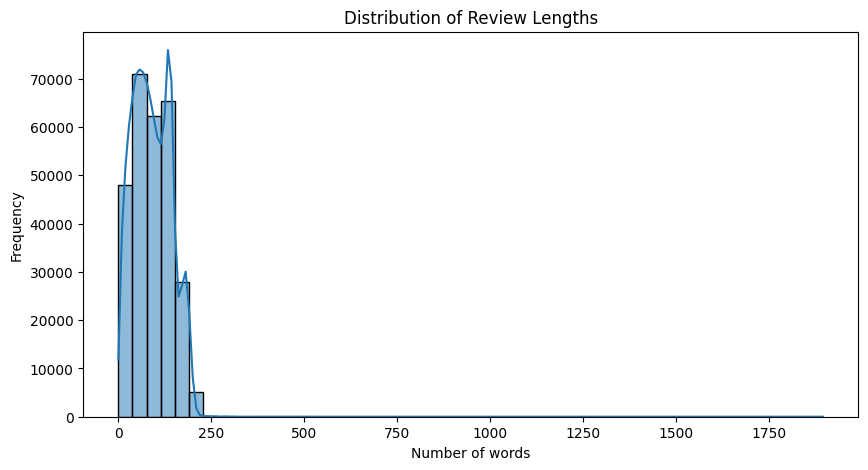

In [ ]:
# Distribution of review length
plt.figure(figsize=(10, 5))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()


# Creating embeddings using S-BERT

In [ ]:
# Checking if the reviews contain HTML, HTTP links and double spacing

has_html = df['Content'].str.contains(r'<[^>]+>', regex=True).sum()
print(f"Number of reviews containing html: {has_html}")

has_links = df['Content'].str.contains(r'http\S+', regex=True).sum()
print(f"Number of reviews containing links: {has_links}")

has_extra_spaces = df['Content'].str.contains(r'\s{2,}', regex=True).sum()
print(f"Number of reviews containing extra spaces: {has_extra_spaces}")


Number of reviews containing html: 10
Number of reviews containing links: 25
Number of reviews containing extra spaces: 112344


In [ ]:
# Cleaning the text
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
# Checking how many rows don't have content / rating
unknown_content = df['Content'].str.lower().str.contains('unknown').sum()
print(f"Number of reviews that don't have content: {unknown_content}")

unknown_rating = df['Rating'].str.lower().str.contains('unknown').sum()
print(f"Number of reviews that don't have numeric rating: {unknown_rating}")

Number of reviews that don't have content: 332
Number of reviews that don't have numeric rating: 0


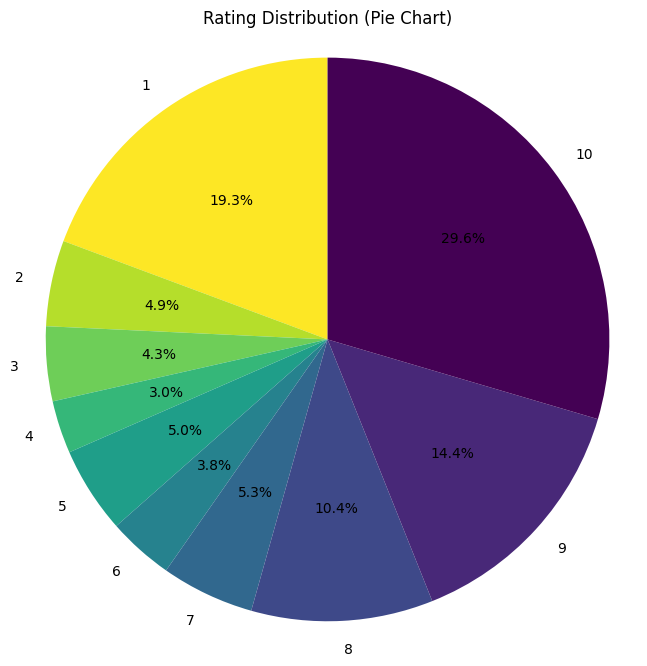

In [ ]:
# Pie-chart of distributions
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
rating_counts = df['Rating'].value_counts().sort_index()

plt.figure(figsize=(8, 8))
plt.pie(rating_counts, labels=rating_counts.index.astype(int), autopct='%1.1f%%', startangle=90,
        colors=plt.cm.viridis_r(np.linspace(0, 1, len(rating_counts))))
plt.title("Rating Distribution (Pie Chart)")
plt.axis('equal')
plt.show()

Deviding the ratings to categories:


*   Positive - Reviews rating 7-10
*   Neutral - Reviews rating 4-6
*   Negative - Reviews rating 1-3

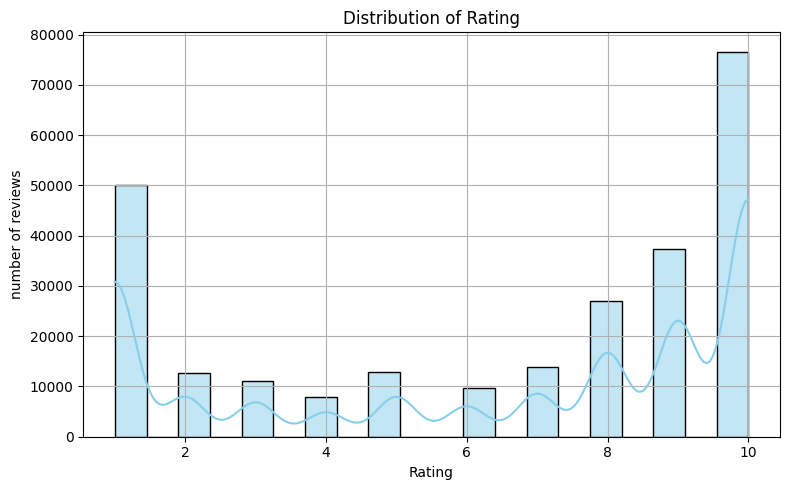

In [ ]:
# Rating Distribution

plt.figure(figsize=(8, 5))
sns.histplot(df['Rating'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('number of reviews')
plt.grid(True)
plt.tight_layout()
plt.show()


# Baseline model - Logistic Regression
## SBERT embeddings - 'all-MiniLM-L6-v2'.
## Label balancing : None.
## Performing on 10,000 reviews.
### Accuracy: 0.644

In [ ]:
def label_from_rating(rating):
    if rating >= 7:
        return 'positive'
    elif rating <= 3:
        return 'negative'
    else:
        return 'neutral'

sample_df = df[df['Rating'].notnull()].sample(n=10000, random_state=42).copy()
sample_df['Rating'] = pd.to_numeric(sample_df['Rating'], errors='coerce')
sample_df['cleaned_content'] = sample_df['Content'].apply(clean_text)
sample_df['true_sentiment'] = sample_df['Rating'].apply(label_from_rating)

In [ ]:
# Creating SBERT embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
sample_df['embeddings'] = sample_df['cleaned_content'].apply(lambda x: model.encode(x))
X = np.vstack(sample_df['embeddings'].values)
y = sample_df['true_sentiment'].values

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


In [ ]:
# Deviding 80% for train and 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Training Logistic Regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [ ]:
# Evaluation report
y_pred = clf.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.644

Classification Report:
              precision    recall  f1-score   support

    negative       0.59      0.55      0.57       518
     neutral       0.42      0.04      0.08       373
    positive       0.67      0.89      0.76      1109

    accuracy                           0.64      2000
   macro avg       0.56      0.49      0.47      2000
weighted avg       0.60      0.64      0.59      2000



# Task number 1: Sentiment Analysis

# Model Number 1: Logistic Regression
## Embeddings: S-BERT 'all-MiniLM-L6-v2'
## Labels balancing technique: None
### Accuracy: 0.668


In [ ]:
def label_from_rating(rating):
    if rating >= 7:
        return 'positive'
    elif rating <= 3:
        return 'negative'
    else:
        return 'neutral'

# Creating embeddings for the entire data
sample_df = df[df['Rating'].notnull()].copy()
sample_df['Rating'] = pd.to_numeric(sample_df['Rating'], errors='coerce')
sample_df['cleaned_content'] = sample_df['Content'].apply(clean_text)
sample_df['true_sentiment'] = sample_df['Rating'].apply(label_from_rating)

model = SentenceTransformer('all-MiniLM-L6-v2')

# Creating vectors
sample_df['embeddings'] = sample_df['cleaned_content'].apply(lambda x: model.encode(x))

X = np.vstack(sample_df['embeddings'].values)
y = sample_df['true_sentiment'].values

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Creating embeddings for the entire data
sample_df = df[df['Rating'].notnull()].copy()
sample_df['Rating'] = pd.to_numeric(sample_df['Rating'], errors='coerce')
sample_df['cleaned_content'] = sample_df['Content'].apply(clean_text)
sample_df['true_sentiment'] = sample_df['Rating'].apply(label_from_rating)

In [ ]:
sentiment_counts = sample_df['true_sentiment'].value_counts()
print(sentiment_counts)

true_sentiment
positive    154761
negative     73942
neutral      51308
Name: count, dtype: int64


In [ ]:
# Splitting the data to 80% train and 20% train
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Training Logistic Regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [ ]:
# Evaluation report
y_pred = clf.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.668

Classification Report:
              precision    recall  f1-score   support

    negative       0.62      0.62      0.62     14788
     neutral       0.40      0.06      0.11     10262
    positive       0.70      0.89      0.78     30953

    accuracy                           0.67     56003
   macro avg       0.57      0.52      0.50     56003
weighted avg       0.62      0.67      0.62     56003



In [ ]:
# As suspected, the labels aren't balanced. We will next try different balancing tecniques.
print(sample_df['true_sentiment'].value_counts())

true_sentiment
positive    154761
negative     73942
neutral      30479
Name: count, dtype: int64


# Model Number 2: Logistic Regression
## Embeddings: S-BERT 'all-MiniLM-L6-v2'
## Labels balancing tecnique: Weights
### Accuracy: 0.604

In [ ]:
# Splitting the data to 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Training Logistic Regression with balanced classes!
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [ ]:
# Evaluation report
y_pred = clf.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.604

Classification Report:
              precision    recall  f1-score   support

    negative       0.58      0.66      0.62     14788
     neutral       0.29      0.40      0.33     10262
    positive       0.80      0.65      0.71     30953

    accuracy                           0.60     56003
   macro avg       0.56      0.57      0.56     56003
weighted avg       0.65      0.60      0.62     56003



# Model Number 3: Logistic Regression
## Embeddings: S-BERT 'all-MiniLM-L6-v2'
## Labels balancing tecnique: Over Sampling from Neutral and Negative classes
### Accuracy: 0.572

In [ ]:
# Splitting the data to 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Over sampling the Negative and Neutral classes to get even with Positive
ros = RandomOverSampler(sampling_strategy={
    'negative': 154761,
    'neutral': 154761
}, random_state=42)


X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Training Logistic Regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_resampled, y_train_resampled)


LogisticRegression(max_iter=1000)

In [ ]:
# Evaluation report
y_pred = clf.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.572

Classification Report:
              precision    recall  f1-score   support

    negative       0.57      0.68      0.62     14788
     neutral       0.27      0.46      0.34     10262
    positive       0.82      0.56      0.67     30953

    accuracy                           0.57     56003
   macro avg       0.56      0.57      0.54     56003
weighted avg       0.66      0.57      0.59     56003



# Model Number 4: Few-shot classification (MiniLM-L6-H384-uncased, from HuggingFace by nreimers
## Embeddings: BERT with fine-tuning using LoRA
## Labels balancing technique: No explicit balancing (only stratified split)
### Accuracy: 0.711


In [ ]:
# Preparing the data, changing the rating value to fit 3 categories for the transformers
def label_from_rating(rating):
    if rating >= 7: # Positive
        return 2
    elif rating <= 3: # Negative
        return 0
    else:
        return 1 # Neutral

df = df[df['Rating'].notnull()].copy()
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df['cleaned_content'] = df['Content'].apply(clean_text)
df['label'] = df['Rating'].apply(label_from_rating)

# Splitting the data to 80% train and 20% test
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['cleaned_content'], df['label'], test_size=0.1, stratify=df['label'], random_state=42
)

# Tokenizer and model from HuggingFace
model_name = "nreimers/MiniLM-L6-H384-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_dataset = Dataset.from_dict({
    'text': train_texts.tolist(),
    'label': train_labels.tolist()
})
val_dataset = Dataset.from_dict({
    'text': val_texts.tolist(),
    'label': val_labels.tolist()
})

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Setting LoRA
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1
)

model = get_peft_model(model, peft_config)

# Training
training_args = TrainingArguments(
    output_dir="./results_lora",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    logging_steps=500
)


# Loading metrice of Accuracy
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.from_numpy(logits).argmax(dim=-1)
    return metric.compute(predictions=predictions.numpy(), references=labels)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

trainer.train()

# Cleaning cache
gc.collect()
torch.cuda.empty_cache()

# Evaluation report
eval_results = trainer.evaluate()
print("Evaluation:", eval_results)

preds = trainer.predict(val_dataset)
y_pred = preds.predictions.argmax(axis=-1)
report = classification_report(val_labels, y_pred, target_names=["Negative", "Neutral", "Positive"], output_dict=True)
pd.DataFrame(report).transpose().to_excel("fewshot_sentiment_report.xlsx")

# Saving the model
trainer.save_model('./fewshot_sentiment_model')
tokenizer.save_pretrained('./fewshot_sentiment_model')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/252009 [00:00<?, ? examples/s]

Map:   0%|          | 0/28002 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nreimers/MiniLM-L6-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-5-5f2780bba826>:83: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


<ipython-input-5-5f2780bba826>:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nikoljabotinski (nikoljabotinski-hit) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,1.011400
1000,0.987300
1500,0.939600
2000,0.881300
2500,0.853300
3000,0.839100
3500,0.826500
4000,0.805100
4500,0.818100
5000,0.801400


Evaluation: {'eval_loss': 0.7011494636535645, 'eval_accuracy': 0.7116991643454039, 'eval_runtime': 34.5793, 'eval_samples_per_second': 809.79, 'eval_steps_per_second': 12.667, 'epoch': 3.0}


('./fewshot_sentiment_model/tokenizer_config.json',
 './fewshot_sentiment_model/special_tokens_map.json',
 './fewshot_sentiment_model/vocab.txt',
 './fewshot_sentiment_model/added_tokens.json',
 './fewshot_sentiment_model/tokenizer.json')

# Model Number 5: Few-shot classification (MiniLM-L6-H384-uncased)
## Embeddings: BERT with fine-tuning using LoRA
## Labels balancing technique: Over Sampling of Negative and Neutral classes
### Accuracy: 0.64


In [ ]:
# Preparing the data, changing the rating value to fit 3 categories for the transformers
def label_from_rating(rating):
    if rating >= 7:
        return 2  # Positive
    elif rating <= 3:
        return 0  # Negative
    else:
        return 1  # Neutral

df = df[df['Rating'].notnull()].copy()
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df['cleaned_content'] = df['Content'].apply(clean_text)
df['label'] = df['Rating'].apply(label_from_rating)

# Over-Sampling
df_majority = df[df['label'] == 2]  # Positive
df_minority_0 = df[df['label'] == 0]  # Negative
df_minority_1 = df[df['label'] == 1]  # Neutral

target_size = df_majority.shape[0]

df_minority_0_upsampled = resample(df_minority_0, replace=True, n_samples=target_size, random_state=42)
df_minority_1_upsampled = resample(df_minority_1, replace=True, n_samples=target_size, random_state=42)

df_oversampled = pd.concat([df_majority, df_minority_0_upsampled, df_minority_1_upsampled])
df_oversampled = df_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Splitting to 10% test and 90% train
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_oversampled['cleaned_content'], df_oversampled['label'],
    test_size=0.1, stratify=df_oversampled['label'], random_state=42
)

# --- Tokenizer + Dataset ---
model_name = "nreimers/MiniLM-L6-H384-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_dataset = Dataset.from_dict({
    'text': train_texts.tolist(),
    'label': train_labels.tolist()
})
val_dataset = Dataset.from_dict({
    'text': val_texts.tolist(),
    'label': val_labels.tolist()
})

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

# Model with LoRA
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1
)

model = get_peft_model(model, peft_config)

# Training
training_args = TrainingArguments(
    output_dir="./results_lora",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    logging_steps=500
)

# Evaluation
from datasets import load_metric
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.from_numpy(logits).argmax(dim=-1)
    return metric.compute(predictions=predictions.numpy(), references=labels)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

trainer.train()

# Cleaning cache
gc.collect()
torch.cuda.empty_cache()

# Final report
eval_results = trainer.evaluate()
print("Evaluation:", eval_results)

preds = trainer.predict(val_dataset)
y_pred = preds.predictions.argmax(axis=-1)
report = classification_report(val_labels, y_pred, target_names=["Negative", "Neutral", "Positive"], output_dict=True)
pd.DataFrame(report).transpose().to_excel("fewshot_sentiment_report.xlsx")

trainer.save_model('./fewshot_sentiment_model')
tokenizer.save_pretrained('./fewshot_sentiment_model')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/417854 [00:00<?, ? examples/s]

Map:   0%|          | 0/46429 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nreimers/MiniLM-L6-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-4-1c9282d79086>:97: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


<ipython-input-4-1c9282d79086>:105: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nikoljabotinski (nikoljabotinski-hit) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,1.098500
1000,1.042300
1500,0.982400
2000,0.963900
2500,0.952800
3000,0.937000
3500,0.926500
4000,0.914900
4500,0.916400
5000,0.903500


Evaluation: {'eval_loss': 0.7813423871994019, 'eval_accuracy': 0.6407417777682052, 'eval_runtime': 56.6897, 'eval_samples_per_second': 819.002, 'eval_steps_per_second': 12.807, 'epoch': 3.0}


('./fewshot_sentiment_model/tokenizer_config.json',
 './fewshot_sentiment_model/special_tokens_map.json',
 './fewshot_sentiment_model/vocab.txt',
 './fewshot_sentiment_model/added_tokens.json',
 './fewshot_sentiment_model/tokenizer.json')

# Model Number 6: XGBoost Classifier
## Embeddings: Sentence-BERT (all-MiniLM-L6-v2)
## Label Balancing Technique: None (but stratified train-test split applied)
## Accuracy = 0.72

In [ ]:
# Making sure the data is correctly proccessed
df["Rating"] = pd.to_numeric(df["Rating"], errors="coerce")
df = df[df["Rating"].notnull()]
df["Rating"] = df["Rating"].astype(int)

<ipython-input-26-2477e11c9f9b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Rating"] = df["Rating"].astype(int)


<ipython-input-28-660674432d0d>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Rating"] = df["Rating"].astype(int)
<ipython-input-28-660674432d0d>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sentiment"] = df["Rating"].apply(label_from_rating)
<ipython-input-28-660674432d0d>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

 יוצר embeddings (עלול לקחת זמן)...


Batches:   0%|          | 0/8100 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:10:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 Classification Report:

              precision    recall  f1-score   support

    negative       0.68      0.61      0.64     14789
     neutral       0.37      0.03      0.05      6096
    positive       0.74      0.91      0.82     30952

    accuracy                           0.72     51837
   macro avg       0.60      0.52      0.50     51837
weighted avg       0.68      0.72      0.68     51837



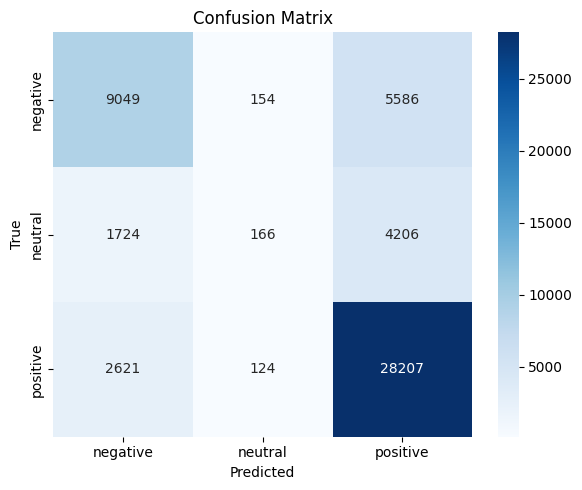

In [ ]:
# Previous code of loading and processing..
path = kagglehub.dataset_download("mukeshdevrath007/drugs-and-conditions-patient-voices-2-8l")
file_path = os.path.join(path, "MedicalReviews_280000.csv")
df = pd.read_csv(file_path)

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df["cleaned_content"] = df["Content"].apply(clean_text)
df["Rating"] = pd.to_numeric(df["Rating"], errors="coerce")
df = df[df["Rating"].notnull()]
df["Rating"] = df["Rating"].astype(int)

def label_from_rating(rating):
    if rating >= 7:
        return "positive"
    elif rating <= 3:
        return "negative"
    else:
        return "neutral"

df["sentiment"] = df["Rating"].apply(label_from_rating)

# Changing class names to numeric values
label_map = {"negative": 0, "neutral": 1, "positive": 2}
df["label"] = df["sentiment"].map(label_map)

# Embeddings of SBERT
model = SentenceTransformer("all-MiniLM-L6-v2")

print(" Creating embeddings ...")
X = model.encode(df["cleaned_content"].tolist(), batch_size=32, show_progress_bar=True)
y = df["label"].values

# Splitting data to 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Training XGBoost
xgb_model = XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

# Classification report
print("\n Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["negative", "neutral", "positive"]))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["negative", "neutral", "positive"],
            yticklabels=["negative", "neutral", "positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


# Model Number 7: XGBoost Classifier
## Embeddings: Sentence-BERT (all-MiniLM-L6-v2)
## Label Balancing Technique: weighted with sample_weight
## Accuracy = 0.65

Class weights: {np.int64(0): np.float64(1.1684107314929082), np.int64(1): np.float64(2.834556863388426), np.int64(2): np.float64(0.558238900241501)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:30:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  msg += " or "



Classification Report:

              precision    recall  f1-score   support

    negative       0.62      0.67      0.64     14789
     neutral       0.24      0.41      0.31      6096
    positive       0.84      0.70      0.76     30952

    accuracy                           0.65     51837
   macro avg       0.57      0.59      0.57     51837
weighted avg       0.71      0.65      0.67     51837



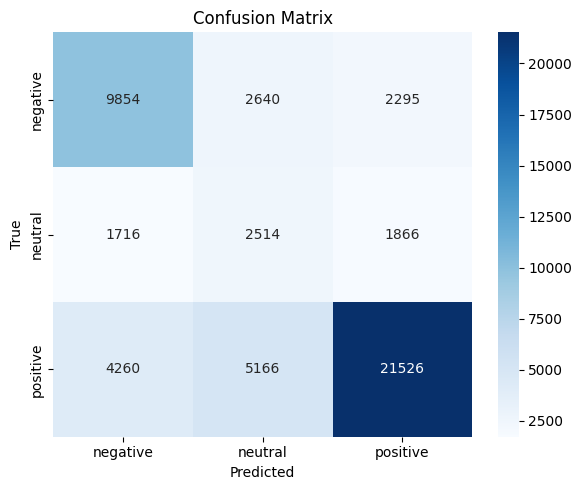

In [ ]:
# Calculating weights for class balancing
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}
print("Class weights:", class_weight_dict)

# Vector of weights for every sample
sample_weights = np.array([class_weight_dict[label] for label in y_train])

# Training XGBoost
xgb_model = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42,
    n_estimators=200,
    learning_rate=0.1
)

xgb_model.fit(
    X_train,
    y_train,
    sample_weight=sample_weights,
    verbose=True
)

# Prediction and results
y_pred = xgb_model.predict(X_test)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=["negative", "neutral", "positive"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["negative", "neutral", "positive"],
            yticklabels=["negative", "neutral", "positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


# Model Number 8: XGBoost Classifier
## Embeddings: Sentence-BERT (all-MiniLM-L6-v2)
## Label Balancing Technique: Oversampling with RandomOverSampler
## Accuracy = 0.66

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7b93a5e6f420>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.11/dist-packages/xgboost.libs/libgomp-24e2ab19.so.1.0.0

Before oversampling: Counter({np.int64(2): 123809, np.int64(0): 59153, np.int64(1): 24383})
After oversampling: Counter({np.int64(0): 123809, np.int64(2): 123809, np.int64(1): 123809})


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:39:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  msg += " or "



Classification Report:

              precision    recall  f1-score   support

    negative       0.62      0.66      0.64     14789
     neutral       0.25      0.41      0.31      6096
    positive       0.83      0.70      0.76     30952

    accuracy                           0.66     51837
   macro avg       0.57      0.59      0.57     51837
weighted avg       0.70      0.66      0.67     51837



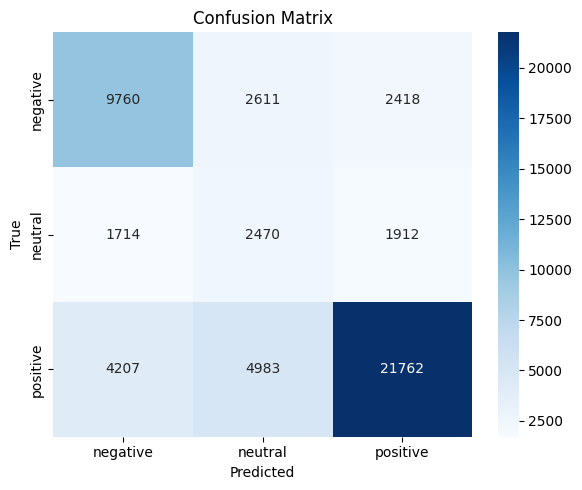

In [ ]:
# Oversampling the training set
ros = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train)

# Printing distributions after balancing
print("Before oversampling:", Counter(y_train))
print("After oversampling:", Counter(y_train_balanced))

# Training XGBoost
xgb_model = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42,
    n_estimators=200,
    learning_rate=0.1
)

xgb_model.fit(
    X_train_balanced,
    y_train_balanced,
    verbose=True
)

# Prediction and results
y_pred = xgb_model.predict(X_test)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=["negative", "neutral", "positive"]))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["negative", "neutral", "positive"],
            yticklabels=["negative", "neutral", "positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Model Number 9: Logistic Regression
## Embeddings: OpenAI - text-embedding-3-small
## Label Balancing Technique: class_weight = 'balanced'
## Accuracy = 0.78

In [ ]:
# Defining client with our key
client = OpenAI(api_key="API_KEY")

In [ ]:
# Function of Embeddings
def get_embeddings_openai(text_list, model="text-embedding-3-small"):
    embeddings = []
    for text in tqdm.tqdm(text_list):
        try:
            response = client.embeddings.create(
                input=text,
                model=model
            )
            embeddings.append(response.data[0].embedding)
        except Exception as e:
            print("Error:", e)
            embeddings.append([0] * 1536)
    return np.array(embeddings)


<ipython-input-9-8ee8c21a9e85>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Rating"] = df["Rating"].astype(int)
<ipython-input-9-8ee8c21a9e85>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sentiment"] = df["Rating"].apply(label_from_rating)
<ipython-input-9-8ee8c21a9e85>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

Creating Embeddings for train..


 87%|████████▋ | 9042/10368 [2:29:45<18:59,  1.16it/s]

שגיאה בבאץ' 180840: Error code: 400 - {'error': {'message': "'$.input' is invalid. Please check the API reference: https://platform.openai.com/docs/api-reference.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


100%|██████████| 10368/10368 [2:51:53<00:00,  1.01it/s]


Creating Embeddings for test..


 41%|████▏     | 1070/2592 [17:42<1:05:03,  2.56s/it]

שגיאה בבאץ' 21400: Error code: 400 - {'error': {'message': "'$.input' is invalid. Please check the API reference: https://platform.openai.com/docs/api-reference.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


100%|██████████| 2592/2592 [42:33<00:00,  1.02it/s]



 Classification report: 

              precision    recall  f1-score   support

    negative       0.84      0.75      0.79     14789
     neutral       0.34      0.65      0.44      6096
    positive       0.95      0.82      0.88     30952

    accuracy                           0.78     51837
   macro avg       0.71      0.74      0.70     51837
weighted avg       0.84      0.78      0.80     51837



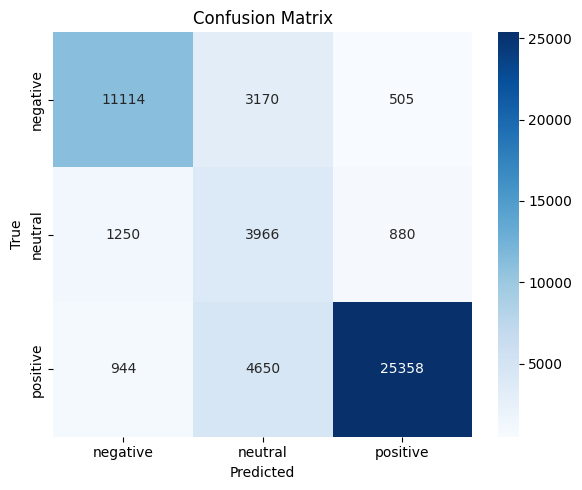

In [ ]:
os.environ["AZURE_OPENAI_API_KEY"] = "API_KEY"
os.environ["AZURE_OPENAI_ENDPOINT"] = "ENDPOINT"
os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"] = "text-embedding-3-small"

api_key = os.environ.get("AZURE_OPENAI_API_KEY")
endpoint = os.environ.get("AZURE_OPENAI_ENDPOINT")
deployment_name = os.environ.get("AZURE_OPENAI_DEPLOYMENT_NAME")

if not all([api_key, endpoint, deployment_name]):
    raise ValueError("Missing parameters for Azure OpenAI.")

# Creating client at Azure OpenAI
client = AzureOpenAI(
    api_key=api_key,
    api_version="2024-02-15-preview",
    azure_endpoint=endpoint
)

# Reading and cleaning data
path = kagglehub.dataset_download("mukeshdevrath007/drugs-and-conditions-patient-voices-2-8l")
file_path = os.path.join(path, "MedicalReviews_280000.csv")
df = pd.read_csv(file_path)

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df["cleaned_content"] = df["Content"].apply(clean_text)
df["Rating"] = pd.to_numeric(df["Rating"], errors="coerce")
df = df[df["Rating"].notnull()]
df["Rating"] = df["Rating"].astype(int)

def label_from_rating(r):
    if r >= 7:
        return "positive"
    elif r <= 3:
        return "negative"
    else:
        return "neutral"

df["sentiment"] = df["Rating"].apply(label_from_rating)
df["label"] = df["sentiment"].map({"negative": 0, "neutral": 1, "positive": 2})

# Splitting to train and test
X_text = df["cleaned_content"].tolist()
y = df["label"].values
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=42
)

# Creating embeddings
def get_embeddings_azure(texts, batch_size=20):
    all_embeddings = []
    for i in tqdm.tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        try:
            response = client.embeddings.create(
                input=batch,
                model=deployment_name
            )
            batch_embeddings = [d.embedding for d in response.data]
        except Exception as e:
            print(f"שגיאה בבאץ' {i}: {e}")
            batch_embeddings = [[0]*1536] * len(batch)  # fallback
        all_embeddings.extend(batch_embeddings)
    return np.array(all_embeddings)

print("Creating Embeddings for train..")
X_train_embed = get_embeddings_azure(X_train_text)

print("Creating Embeddings for test..")
X_test_embed = get_embeddings_azure(X_test_text)

# Training Logistic Regression
clf = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
clf.fit(X_train_embed, y_train)

# Prediction and results
y_pred = clf.predict(X_test_embed)
print("\n Classification report: \n")
print(classification_report(y_test, y_pred, target_names=["negative", "neutral", "positive"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["negative", "neutral", "positive"],
            yticklabels=["negative", "neutral", "positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


# Model Number 10: Logistic Regression
## Embeddings: OpenAI - text-embedding-3-small
## Label Balancing Technique: Over Sampling
## Accuracy = 0.78


<ipython-input-4-aada44db9bb8>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Rating"] = df["Rating"].astype(int)
<ipython-input-4-aada44db9bb8>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sentiment"] = df["Rating"].apply(label_from_rating)
<ipython-input-4-aada44db9bb8>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

Creating Embeddings for train..


 87%|████████▋ | 9044/10368 [2:28:59<14:25,  1.53it/s]

שגיאה בבאץ' 180840: Error code: 400 - {'error': {'message': "'$.input' is invalid. Please check the API reference: https://platform.openai.com/docs/api-reference.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


100%|██████████| 10368/10368 [2:50:24<00:00,  1.01it/s]


Creating Embeddings for test..


 41%|████▏     | 1071/2592 [17:43<2:14:36,  5.31s/it]

שגיאה בבאץ' 21400: Error code: 400 - {'error': {'message': "'$.input' is invalid. Please check the API reference: https://platform.openai.com/docs/api-reference.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


100%|██████████| 2592/2592 [42:32<00:00,  1.02it/s]


Applying Oversampling..

Classification report:

              precision    recall  f1-score   support

    negative       0.83      0.75      0.79     14789
     neutral       0.33      0.65      0.44      6096
    positive       0.95      0.82      0.88     30952

    accuracy                           0.78     51837
   macro avg       0.70      0.74      0.70     51837
weighted avg       0.84      0.78      0.80     51837



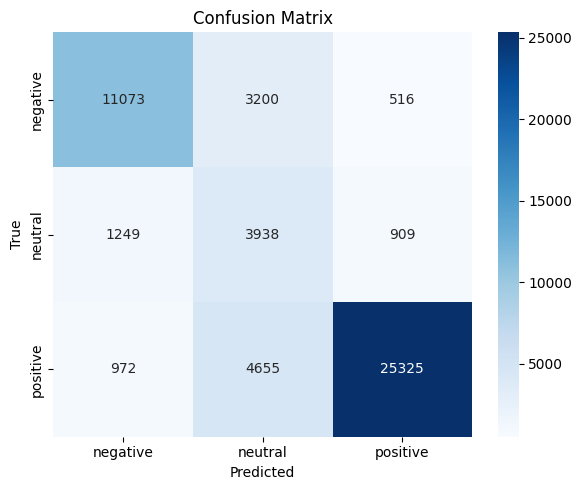

In [ ]:
# Azure OpenAI parameters
os.environ["AZURE_OPENAI_API_KEY"] = "API_KEY"
os.environ["AZURE_OPENAI_ENDPOINT"] = "ENDPOINT"
os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"] = "text-embedding-3-small"

api_key = os.environ.get("AZURE_OPENAI_API_KEY")
endpoint = os.environ.get("AZURE_OPENAI_ENDPOINT")
deployment_name = os.environ.get("AZURE_OPENAI_DEPLOYMENT_NAME")

if not all([api_key, endpoint, deployment_name]):
    raise ValueError("Missing parameters for Azure OpenAI.")

# Client for Azure OpenAI
client = AzureOpenAI(
    api_key=api_key,
    api_version="2024-02-15-preview",
    azure_endpoint=endpoint
)

# Read and clean data
path = kagglehub.dataset_download("mukeshdevrath007/drugs-and-conditions-patient-voices-2-8l")
file_path = os.path.join(path, "MedicalReviews_280000.csv")
df = pd.read_csv(file_path)

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df["cleaned_content"] = df["Content"].apply(clean_text)
df["Rating"] = pd.to_numeric(df["Rating"], errors="coerce")
df = df[df["Rating"].notnull()]
df["Rating"] = df["Rating"].astype(int)

def label_from_rating(r):
    if r >= 7:
        return "positive"
    elif r <= 3:
        return "negative"
    else:
        return "neutral"

df["sentiment"] = df["Rating"].apply(label_from_rating)
df["label"] = df["sentiment"].map({"negative": 0, "neutral": 1, "positive": 2})

# Split to train and test
X_text = df["cleaned_content"].tolist()
y = df["label"].values
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=42
)

# Create embeddings
def get_embeddings_azure(texts, batch_size=20):
    all_embeddings = []
    for i in tqdm.tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        try:
            response = client.embeddings.create(
                input=batch,
                model=deployment_name
            )
            batch_embeddings = [d.embedding for d in response.data]
        except Exception as e:
            print(f"שגיאה בבאץ' {i}: {e}")
            batch_embeddings = [[0]*1536] * len(batch)  # fallback
        all_embeddings.extend(batch_embeddings)
    return np.array(all_embeddings)

print("Creating Embeddings for train..")
X_train_embed = get_embeddings_azure(X_train_text)

print("Creating Embeddings for test..")
X_test_embed = get_embeddings_azure(X_test_text)

# Oversampling
print("Applying Oversampling..")
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_embed, y_train)

# Train Logistic Regression
clf = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Predict and evaluate
y_pred = clf.predict(X_test_embed)
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=["negative", "neutral", "positive"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["negative", "neutral", "positive"],
            yticklabels=["negative", "neutral", "positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Model Number 11: Logistic Regression
## Embeddings: OpenAI - text-embedding-3-small
## Label Balancing Technique: None
## Accuracy = 0.82


<ipython-input-5-43b6357462f7>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Rating"] = df["Rating"].astype(int)
<ipython-input-5-43b6357462f7>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sentiment"] = df["Rating"].apply(label_from_rating)
<ipython-input-5-43b6357462f7>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

Creating Embeddings for train..


 87%|████████▋ | 9044/10368 [2:29:38<08:56,  2.47it/s]

שגיאה בבאץ' 180840: Error code: 400 - {'error': {'message': "'$.input' is invalid. Please check the API reference: https://platform.openai.com/docs/api-reference.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


100%|██████████| 10368/10368 [2:51:19<00:00,  1.01it/s]


Creating Embeddings for test..


 41%|████▏     | 1071/2592 [17:22<17:08,  1.48it/s]

שגיאה בבאץ' 21400: Error code: 400 - {'error': {'message': "'$.input' is invalid. Please check the API reference: https://platform.openai.com/docs/api-reference.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


100%|██████████| 2592/2592 [42:50<00:00,  1.01it/s]


Training logistic regression without class_weight or oversampling..

Classification report:

              precision    recall  f1-score   support

    negative       0.78      0.85      0.81     14789
     neutral       0.45      0.19      0.27      6096
    positive       0.87      0.93      0.90     30952

    accuracy                           0.82     51837
   macro avg       0.70      0.66      0.66     51837
weighted avg       0.80      0.82      0.80     51837



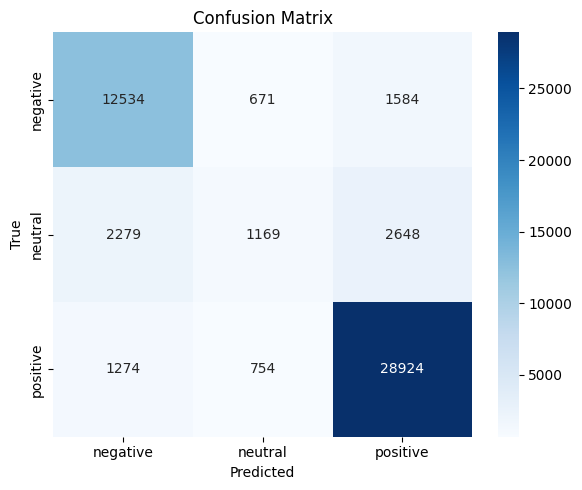

In [ ]:
# Azure OpenAI parameters
os.environ["AZURE_OPENAI_API_KEY"] = "API_KEY"
os.environ["AZURE_OPENAI_ENDPOINT"] = "ENDPOINT"
os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"] = "text-embedding-3-small"

api_key = os.environ.get("AZURE_OPENAI_API_KEY")
endpoint = os.environ.get("AZURE_OPENAI_ENDPOINT")
deployment_name = os.environ.get("AZURE_OPENAI_DEPLOYMENT_NAME")

if not all([api_key, endpoint, deployment_name]):
    raise ValueError("Missing parameters for Azure OpenAI.")

# Azure OpenAI client
client = AzureOpenAI(
    api_key=api_key,
    api_version="2024-02-15-preview",
    azure_endpoint=endpoint
)

# Read and clean data
path = dataset_download("mukeshdevrath007/drugs-and-conditions-patient-voices-2-8l")
file_path = os.path.join(path, "MedicalReviews_280000.csv")
df = pd.read_csv(file_path)

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df["cleaned_content"] = df["Content"].apply(clean_text)
df["Rating"] = pd.to_numeric(df["Rating"], errors="coerce")
df = df[df["Rating"].notnull()]
df["Rating"] = df["Rating"].astype(int)

def label_from_rating(r):
    if r >= 7:
        return "positive"
    elif r <= 3:
        return "negative"
    else:
        return "neutral"

df["sentiment"] = df["Rating"].apply(label_from_rating)
df["label"] = df["sentiment"].map({"negative": 0, "neutral": 1, "positive": 2})

# Train-test split
X_text = df["cleaned_content"].tolist()
y = df["label"].values
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=42
)

# Embeddings
def get_embeddings_azure(texts, batch_size=20):
    all_embeddings = []
    for i in tqdm.tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        try:
            response = client.embeddings.create(
                input=batch,
                model=deployment_name
            )
            batch_embeddings = [d.embedding for d in response.data]
        except Exception as e:
            print(f"שגיאה בבאץ' {i}: {e}")
            batch_embeddings = [[0]*1536] * len(batch)
        all_embeddings.extend(batch_embeddings)
    return np.array(all_embeddings)

print("Creating Embeddings for train..")
X_train_embed = get_embeddings_azure(X_train_text)

print("Creating Embeddings for test..")
X_test_embed = get_embeddings_azure(X_test_text)

# Logistic regression without any balancing
print("Training logistic regression without class_weight or oversampling..")
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_embed, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test_embed)

print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=["negative", "neutral", "positive"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["negative", "neutral", "positive"],
            yticklabels=["negative", "neutral", "positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


# Task Number 2: Regression of Reviews
### Predicting a rating value as close as possible to the gold standart.


# Model Number 1: Linear Regression
## Embeddings: S-BERT (all-MiniLM-L6-v2)
## Labels balancing technique: None
### MAE = 2.38 (In a scale of 1-10)

In [ ]:
# Proccesing the data
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df = df[df['Rating'].notnull()].copy()

df['cleaned_content'] = df['Content'].apply(clean_text)

# Creating embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
df['embeddings'] = df['cleaned_content'].apply(lambda x: model.encode(x))

# Linear Regression on embeddings
X = np.vstack(df['embeddings'].values)
y = df['Rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R² Score:{r2:.2f}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.3 MB/s eta 0:00:00
MAE: 2.38
MSE: 8.23
R² Score:0.34



# Model Number 2: K-Nearest Neighbors Regression (k=5)
## Embeddings: S-BERT (all-MiniLM-L6-v2)
## Labels balancing technique: None
### MAE = 2.18 (In a scale of 1-10)

In [ ]:
# Using the same enbeddings we created for the previous model

model = SentenceTransformer('all-MiniLM-L6-v2')

df['embeddings'] = df['cleaned_content'].apply(lambda x: model.encode(x))

X = np.vstack(df['embeddings'].values)
y = df['Rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training KNN regression
knn_reg = KNeighborsRegressor(n_neighbors=5, metric='cosine')  # אפשר גם 'euclidean'
knn_reg.fit(X_train, y_train)

# Prediction
y_pred_knn = knn_reg.predict(X_test)

# Model Evaluation
mae_knn = mean_absolute_error(y_test, y_pred_knn)
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(" KNN Regressor Results:")
print(f"MAE: {mae_knn:.2f}")
print(f"MSE: {mse_knn:.2f}")
print(f"R² Score: {r2_knn:.2f}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.2 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

🔍 KNN Regressor Results:
MAE: 2.18
MSE: 8.18
R² Score: 0.34


#  Saving files of SBERT embeddings for the next models

In [ ]:
# Creating a directory
output_dir = "output_embeddings"
os.makedirs(output_dir, exist_ok=True)

# Text Processing
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_content'] = df['Content'].apply(clean_text)
texts = df['cleaned_content'].tolist()

# SBERT
model = SentenceTransformer('all-MiniLM-L6-v2')

# Parameters to saving efficiently
batch_size = 32
chunk_size = 10000
num_chunks = ceil(len(texts) / chunk_size)

# Checking if the files exist already
for i in range(num_chunks):
    start = i * chunk_size
    end = min((i + 1) * chunk_size, len(texts))
    chunk_texts = texts[start:end]

    filename = os.path.join(output_dir, f"embeddings_part_{i}.pkl")

    if os.path.exists(filename):
        print(f"  part {i+1} already exists, skipping..")
        continue

    print(f" creating embeddings for chunk {i+1}/{num_chunks} ({start} עד {end})...")
    chunk_embeddings = model.encode(chunk_texts, batch_size=batch_size, show_progress_bar=True)

    with open(filename, "wb") as f:
        pickle.dump(chunk_embeddings, f)

    print(f" saved as part {i+1} {filename}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

 creating embeddings for chunk 1/29 (0 עד 10000)...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

 saved as part 1 output_embeddings/embeddings_part_0.pkl
 creating embeddings for chunk 2/29 (10000 עד 20000)...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

 saved as part 2 output_embeddings/embeddings_part_1.pkl
 creating embeddings for chunk 3/29 (20000 עד 30000)...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

 saved as part 3 output_embeddings/embeddings_part_2.pkl
 creating embeddings for chunk 4/29 (30000 עד 40000)...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

 saved as part 4 output_embeddings/embeddings_part_3.pkl
 creating embeddings for chunk 5/29 (40000 עד 50000)...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

 saved as part 5 output_embeddings/embeddings_part_4.pkl
 creating embeddings for chunk 6/29 (50000 עד 60000)...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

 saved as part 6 output_embeddings/embeddings_part_5.pkl
 creating embeddings for chunk 7/29 (60000 עד 70000)...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

 saved as part 7 output_embeddings/embeddings_part_6.pkl
 creating embeddings for chunk 8/29 (70000 עד 80000)...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

 saved as part 8 output_embeddings/embeddings_part_7.pkl
 creating embeddings for chunk 9/29 (80000 עד 90000)...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

 saved as part 9 output_embeddings/embeddings_part_8.pkl
 creating embeddings for chunk 10/29 (90000 עד 100000)...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

 saved as part 10 output_embeddings/embeddings_part_9.pkl
 creating embeddings for chunk 11/29 (100000 עד 110000)...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

 saved as part 11 output_embeddings/embeddings_part_10.pkl
 creating embeddings for chunk 12/29 (110000 עד 120000)...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

 saved as part 12 output_embeddings/embeddings_part_11.pkl
 creating embeddings for chunk 13/29 (120000 עד 130000)...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

 saved as part 13 output_embeddings/embeddings_part_12.pkl
 creating embeddings for chunk 14/29 (130000 עד 140000)...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

 saved as part 14 output_embeddings/embeddings_part_13.pkl
 creating embeddings for chunk 15/29 (140000 עד 150000)...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

 saved as part 15 output_embeddings/embeddings_part_14.pkl
 creating embeddings for chunk 16/29 (150000 עד 160000)...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

 saved as part 16 output_embeddings/embeddings_part_15.pkl
 creating embeddings for chunk 17/29 (160000 עד 170000)...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

 saved as part 17 output_embeddings/embeddings_part_16.pkl
 creating embeddings for chunk 18/29 (170000 עד 180000)...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

 saved as part 18 output_embeddings/embeddings_part_17.pkl
 creating embeddings for chunk 19/29 (180000 עד 190000)...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

 saved as part 19 output_embeddings/embeddings_part_18.pkl
 creating embeddings for chunk 20/29 (190000 עד 200000)...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

 saved as part 20 output_embeddings/embeddings_part_19.pkl
 creating embeddings for chunk 21/29 (200000 עד 210000)...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

 saved as part 21 output_embeddings/embeddings_part_20.pkl
 creating embeddings for chunk 22/29 (210000 עד 220000)...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

 saved as part 22 output_embeddings/embeddings_part_21.pkl
 creating embeddings for chunk 23/29 (220000 עד 230000)...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

 saved as part 23 output_embeddings/embeddings_part_22.pkl
 creating embeddings for chunk 24/29 (230000 עד 240000)...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

 saved as part 24 output_embeddings/embeddings_part_23.pkl
 creating embeddings for chunk 25/29 (240000 עד 250000)...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

 saved as part 25 output_embeddings/embeddings_part_24.pkl
 creating embeddings for chunk 26/29 (250000 עד 260000)...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

 saved as part 26 output_embeddings/embeddings_part_25.pkl
 creating embeddings for chunk 27/29 (260000 עד 270000)...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

 saved as part 27 output_embeddings/embeddings_part_26.pkl
 creating embeddings for chunk 28/29 (270000 עד 280000)...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

 saved as part 28 output_embeddings/embeddings_part_27.pkl
 creating embeddings for chunk 29/29 (280000 עד 280012)...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 saved as part 29 output_embeddings/embeddings_part_28.pkl


In [ ]:
# Creating a file of all embeddings
output_dir = "output_embeddings"
merged_file = os.path.join(output_dir, "embeddings_all.pkl")

if os.path.exists(merged_file):
    print(f"The file already exists: {merged_file}")
else:
    # Saving by file order
    part_files = sorted([
        f for f in os.listdir(output_dir)
        if f.startswith("embeddings_part_") and f.endswith(".pkl")
    ], key=lambda x: int(re.search(r'\d+', x).group()))

    if not part_files:
        print("No files exist.")
    else:
        all_embeddings = []

        for f in part_files:
            full_path = os.path.join(output_dir, f)
            print(f" Loading.. : {f}")
            with open(full_path, "rb") as file:
                embeddings = pickle.load(file)
                all_embeddings.append(embeddings)

        merged_embeddings = np.vstack(all_embeddings)
        print(f" United {len(all_embeddings)} files, matrix shape: {merged_embeddings.shape}")

        with open(merged_file, "wb") as f:
            pickle.dump(merged_embeddings, f)

        print(f"Saved successfuly as: {merged_file}")


📥 טוען: embeddings_part_0.pkl
📥 טוען: embeddings_part_1.pkl
📥 טוען: embeddings_part_2.pkl
📥 טוען: embeddings_part_3.pkl
📥 טוען: embeddings_part_4.pkl
📥 טוען: embeddings_part_5.pkl
📥 טוען: embeddings_part_6.pkl
📥 טוען: embeddings_part_7.pkl
📥 טוען: embeddings_part_8.pkl
📥 טוען: embeddings_part_9.pkl
📥 טוען: embeddings_part_10.pkl
📥 טוען: embeddings_part_11.pkl
📥 טוען: embeddings_part_12.pkl
📥 טוען: embeddings_part_13.pkl
📥 טוען: embeddings_part_14.pkl
📥 טוען: embeddings_part_15.pkl
📥 טוען: embeddings_part_16.pkl
📥 טוען: embeddings_part_17.pkl
📥 טוען: embeddings_part_18.pkl
📥 טוען: embeddings_part_19.pkl
📥 טוען: embeddings_part_20.pkl
📥 טוען: embeddings_part_21.pkl
📥 טוען: embeddings_part_22.pkl
📥 טוען: embeddings_part_23.pkl
📥 טוען: embeddings_part_24.pkl
📥 טוען: embeddings_part_25.pkl
📥 טוען: embeddings_part_26.pkl
📥 טוען: embeddings_part_27.pkl
📥 טוען: embeddings_part_28.pkl
🧩 אוחדו 29 קבצים - צורת מטריצה: (280012, 384)
✅ נשמר בהצלחה כ־output_embeddings/embeddings_all.pkl


# Model Number 3: Ridge Regression (alpha=1.0)  
## Embeddings: Sentence-BERT ('all-MiniLM-L6-v2')  
## Label Balancing Technique: None  
### Evaluation Metric (MAE): 3.14 (on a rating scale of 1 to 10)


In [ ]:
# Using saved embeddings
with open("embeddings_all.pkl", "rb") as f:
    X = pickle.load(f)

# Loading data
df = pd.read_csv(file_path)
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df = df[df['Rating'].notnull()]
y = df['Rating'].values[:X.shape[0]]

# Splitting the data to 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = Ridge(alpha=1.0)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

# Results
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R²: {r2_score(y_test,y_pred):.2f}")

MAE: 3.14
MSE: 12.24
R²: 0.02


# Task Number 3: Side effects chat-bot
## Based on reviews classified as Negative from the Logistic Regression model with SBERT embeddings and unbalanced data, we aim to create a RAG system for side effects extraction.

In [ ]:
# 50 most common drugs
print(" Top 50 Drug Names:")
top_drugs = df['Drug Name'].value_counts().head(50)
for drug, count in top_drugs.items():
    print(f"{drug}: {count}")

print("\n" + "="*60 + "\n")

# 50 most common conditions
print(" Top 50 Conditions:")
top_conditions = df['Condition'].value_counts().head(50)
for condition, count in top_conditions.items():
    print(f"{condition}: {count}")


 Top 50 Drug Names:
Levonorgestrel: 9688
Junel: 7318
Nexplanon: 4830
Sertraline: 4376
Escitalopram: 3819
Phentermine: 2962
Bupropion: 2782
Plan B: 2772
Yaz 28: 2732
Venlafaxine: 2699
Gabapentin: 2482
Metronidazole: 2411
Duloxetine: 2403
Medroxyprogesterone: 2400
Lexapro: 2252
Citalopram: 2203
Fluoxetine: 2162
Quetiapine: 2121
Clonazepam: 2072
Mirtazapine: 1981
Semaglutide: 1943
Nitrofurantoin: 1841
Tramadol: 1825
Zoloft: 1821
Cymbalta: 1764
Amitriptyline: 1744
Lamotrigine: 1715
Sulfamethoxazole and trimethoprim: 1709
Varenicline: 1679
Doxycycline Hyclate: 1621
Doxycycline: 1621
Kyleena: 1604
Pregabalin: 1601
Bisacodyl: 1568
Norethindrone: 1531
Paroxetine: 1511
Loestrin 24 Fe : 1508
Aripiprazole: 1468
Alprazolam: 1450
Saxenda: 1441
Trazodone: 1397
Hydroxyzine: 1362
Hydroxyzine Pamoate: 1362
Propranolol: 1345
Desvenlafaxine: 1342
Buspirone: 1319
Hydrocodone and Acetaminophen: 1305
Paragard: 1291
Topiramate: 1290
Azithromycin: 1287


 Top 50 Conditions:
Birth Control: 30519
Depression: 17

In [ ]:
# Checking how many different drugs and conditions exist
num_unique_drugs = df['Drug Name'].nunique()
num_unique_conditions = df['Condition'].nunique()

print(f"\n Unique drugs: {num_unique_drugs}")
print(f" Unique conditions: {num_unique_conditions}")



 Unique drugs: 1021
 Unique conditions: 965


In [ ]:
# Counting negative classified reviews
negative_count = (sample_df['true_sentiment'] == 'negative').sum()
print(f"Number of negative reviews: {negative_count}")

# Creating a data frame for them
negative_df = sample_df[sample_df['true_sentiment'] == 'negative'].copy()

print(negative_df[['Rating', 'Content']].head())

Number of negative reviews: 73942
    Rating                                            Content
12     1.0  "This medication has ruined my self esteem and...
22     1.0  "I took this medication for about two months I...
24     1.0  "My first week I felt like a whole new person....
27     1.0  "I was on 5 mg Abilify for 5 months. I had fre...
28     2.0  "Be careful, Abilify caused a massive compulsi...


In [ ]:
# Making sure the reviews don't have special characters
if 'cleaned_content' not in negative_df.columns:
    def clean_text(text):
        text = str(text).lower()
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    negative_df['cleaned_content'] = negative_df['Content'].apply(clean_text)

# Saving as an excel file
negative_df.to_excel("negative_reviews.xlsx", index=False)

print("Saved negative_reviews.xlsx!")


קובץ negative_reviews.xlsx נשמר בהצלחה!


## Loading and working with the new data frame

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/negative_reviews.xlsx'
negative_df = pd.read_excel(path)

negative_df.head()

,Drug Name,Condition,User,Date,Rating,Content,cleaned_content,true_sentiment,embeddings
0,Abilify,Bipolar Disorder,Hello...,6-Feb-20,1,"""This medication has ruined my self esteem and...","""this medication has ruined my self esteem and...",negative,[-1.58341564e-02 8.29345509e-02 3.71700823e-...
1,Abilify,Bipolar Disorder,ailik,28-May-20,1,"""I took this medication for about two months I...","""i took this medication for about two months i...",negative,[-1.42054399e-04 6.86467290e-02 2.34886655e-...
2,Abilify,Bipolar Disorder,TJF,22-Nov-22,1,"""My first week I felt like a whole new person....","""my first week i felt like a whole new person....",negative,[-3.67536247e-02 -6.59441529e-03 4.17266786e-...
3,Abilify,Bipolar Disorder,Hilda,9-Nov-22,1,"""I was on 5 mg Abilify for 5 months. I had fre...","""i was on 5 mg abilify for 5 months. i had fre...",negative,[ 2.25077141e-02 -1.51964249e-02 -2.23592715e-...
4,Abilify,Bipolar Disorder,Bill,2-Feb-20,2,"""Be careful, Abilify caused a massive compulsi...","""be careful, abilify caused a massive compulsi...",negative,[ 3.24481130e-02 1.02538255e-03 -7.21499920e-...


# Extracting side effects by NER
## Results not good enough

In [ ]:
#Checking which kind of entities exist in our data

# Loading the model and tokenizer
model_name = "d4data/biomedical-ner-all"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

negative_df = negative_df[negative_df['Content'].apply(lambda x: isinstance(x, str))]

side_effects_by_drug = defaultdict(list)

for _, row in negative_df.iterrows():
    drug = str(row['Drug Name']).strip().lower()
    text = row['Content']

    try:
        entities = ner_pipeline(text)
        if entities:
            print(f"\n{drug.title()} - entities found:")
        for ent in entities:
            print(f"  {ent['word']} -> {ent['entity_group']}")
    except Exception as e:
        print(f"Error at text : {text[:100]}... => {e}")
        continue

side_effects_by_drug = {
    drug: sorted(set(effects)) for drug, effects in side_effects_by_drug.items() if effects
}

print("\n--- Examples of side effects:---\n")
for drug, effects in list(side_effects_by_drug.items())[:5]:
    print(f"{drug.title()}:\n  - " + "\n  - ".join(effects[:10]))


Device set to use cuda:0



Abilify - entities found:
  50 lbs -> Lab_value
  50 -> Lab_value
  lbs -> Lab_value

Abilify - entities found:
  two months -> Duration
  mania -> Sign_symptom
  psychotic -> Detailed_description

Abilify - entities found:
  week -> Duration
  extreme -> Severity
  trapped -> Sign_symptom
  lost weight -> Sign_symptom
  twitching uncontrollably -> Sign_symptom
  dr -> Nonbiological_location
  benad -> Medication
  ##ryl -> Medication
  benad -> Medication
  everyday -> Frequency
  2 weeks -> Duration
  relief -> Sign_symptom
  5 / 10 -> Lab_value
  anxiety -> Sign_symptom
  sky rocket -> Lab_value
  panic -> Sign_symptom
  cold turkey -> Activity
  after a -> Date
  week -> Duration
  chest -> Biological_structure
  pain -> Sign_symptom
  legs -> Biological_structure
  still -> Sign_symptom

Abilify - entities found:
  5 mg -> Dosage
  ab -> Therapeutic_procedure
  ##fy -> Therapeutic_procedure
  5 -> Duration
  frequent -> Detailed_description
  muscle -> Biological_structure
  ins 

KeyboardInterrupt: 

In [ ]:
entity_types = Counter()

# Checking how much does the entities appear based on 100 reviews
for _, row in negative_df.head(1000).iterrows():
    text = row['Content']
    try:
        entities = ner_pipeline(text)
        for ent in entities:
            entity_types[ent['entity_group']] += 1
    except:
        continue

for ent_type, count in entity_types.most_common():
    print(f"{ent_type}: {count}")


Sign_symptom: 3493
Medication: 2016
Detailed_description: 928
Duration: 831
Biological_structure: 751
Disease_disorder: 598
Lab_value: 592
Dosage: 361
Date: 352
Diagnostic_procedure: 326
Activity: 287
Severity: 268
Therapeutic_procedure: 252
History: 242
Nonbiological_location: 220
Frequency: 183
Subject: 170
Coreference: 156
Administration: 155
Clinical_event: 129
Time: 108
Age: 70
Family_history: 40
Outcome: 36
Quantitative_concept: 26
Sex: 19
Occupation: 17
Other_event: 15
Color: 14
Other_entity: 10
Shape: 4
Qualitative_concept: 2
Area: 2
Distance: 2
Texture: 1
Personal_background: 1


In [ ]:
# Loading the model and tokenizer
model_name = "d4data/biomedical-ner-all"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# Creating NER pipeline
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

# Filtering relevant enteties
relevant_entities = {
    "Sign_symptom", "Disease_disorder", "History",
    "Clinical_event", "Outcome", "Other_event"
}

# Storing side effects by drug name
side_effects_by_drug = defaultdict(list)

for _, row in negative_df.iterrows():
    drug = str(row['Drug Name']).strip().lower()
    text = row['Content']
    try:
        entities = ner_pipeline(text)
        for ent in entities:
            if ent['entity_group'] in relevant_entities:
                side_effects_by_drug[drug].append(ent['word'].lower())
    except Exception as e:
        print(f"Error on row: {e}")
        continue

# Removing duplicates
side_effects_by_drug = {
    drug: list(set(effects))
    for drug, effects in side_effects_by_drug.items()
    if effects
}

for drug, effects in list(side_effects_by_drug.items())[:5]:
    print(f"{drug.title()}: {', '.join(effects[:10])}")

Device set to use cuda:0


Abilify: ##se, panic, visit, fear, blow up, ##pati, ener, aggressive, unable to sit still, ##om
Abilify Maintena: nothing productive, desire, t keep still, passed, lost myself, water works, can, ##sti, tiredness, shaking
Abiraterone: in, cancer, died, ga, heart attack, vomiting, unable to walk, ##mptom, dia, weakness
Acetaminophen: headache, relief, many times, fi, pain - relief effect, upset, overdose, mad, offended, hospital
Acetazolamide: panic, ##pati, numbness, tumor cerebri, ##chlore, hypertension, eaten, worse, weak, low energy


In [ ]:
# Trying to clean and get a list of side effects to get a better result
def clean_effect(word):
    word = word.strip().lower()
    if len(word) < 3:
        return None
    if word.startswith("##") or re.search(r'\d', word):
        return None
    if re.search(r'[^a-zA-Z\- ]', word):
        return None
    return word

cleaned_side_effects_by_drug = {}

for drug, effects in side_effects_by_drug.items():
    cleaned = set()
    for word in effects:
        clean = clean_effect(word)
        if clean:
            cleaned.add(clean)
    if cleaned:
        cleaned_side_effects_by_drug[drug] = sorted(cleaned)

for drug, effects in list(cleaned_side_effects_by_drug.items())[:5]:
    print(f" {drug.title()}:\n - " + "\n - ".join(effects[:10]) + "\n")


 Abilify:
 - a nightmare
 - abilify
 - ache
 - ached
 - aching
 - adhd
 - admitted
 - affect
 - affects
 - afraid

 Abilify Maintena:
 - admitted
 - anxiety
 - bipolar
 - can
 - careless
 - con
 - del
 - depression
 - desire
 - difficulty breathing

 Abiraterone:
 - cancer
 - dia
 - died
 - heart attack
 - nausea
 - pain
 - tired
 - tumor
 - unable to walk
 - vomiting

 Acetaminophen:
 - arthritis
 - astonished
 - broken bones
 - cracked
 - headache
 - hospital
 - hurts
 - ill than i am
 - mad
 - many times

 Acetazolamide:
 - ache
 - adjust
 - affects
 - allergic reaction
 - altitude sickness
 - anxiety
 - appetite
 - asleep
 - attack
 - awake



In [ ]:
# Activating a chatbot based on the cleaned list
def chatbot():
    print(" Welcome! Write a name of a medication from the dataset.")
    print("To stop, enter 'exit'.\n")

    while True:
        user_input = input("Medication: ").strip().lower()

        if user_input == "exit":
            print("Goodbye ")
            break

        if user_input in cleaned_side_effects_by_drug:
            effects = cleaned_side_effects_by_drug[user_input]
            print(f"\n🩺 Side effects for '{user_input.title()}':")
            for effect in effects[:10]:
                print(f" - {effect}")
            print()
        else:
            print(f"\n No side effects were found for '{user_input.title()}' or it doesn't exist in the system.\n")

chatbot()


 Welcome! Write a name of a medication from the dataset.
To stop, enter 'exit'.

Medication: Yaz 28

🩺 Side effects for 'Yaz 28':
 - - confrontational
 - - headed
 - - social
 - a crazy
 - a kid
 - a pimple
 - able
 - abnormal appetite
 - absent
 - abusive to

Medication: Loestrin 24 Fe

🩺 Side effects for 'Loestrin 24 Fe':
 - - like symptoms
 - a bad reaction
 - a kid
 - a pimple in
 - able
 - ache
 - aches
 - acne
 - acne prone
 - acted



KeyboardInterrupt: Interrupted by user

# RAG approched chatbot
Initially, we experimented with a Named Entity Recognition (NER) approach to extract relevant information, focusing on identifying key entities within user queries. However, the results lacked the precision and context required for accurate responses. Due to these limitations, we transitioned to a Retrieval-Augmented Generation (RAG) strategy, which combines retrieval of relevant documents with generative language capabilities, resulting in significantly more accurate and context-aware responses.

In [ ]:
# Making sure there are no reviews with missing values
negative_reviews = negative_df[["Drug Name", "Content"]].dropna()

# Creating a document for every entry
documents = []

for _, row in negative_reviews.iterrows():
    drug = row['Drug Name'].strip()
    content = row['Content'].strip()
    doc = f"Drug: {drug}\nReview: {content}"
    documents.append(doc)

print(f"{len(documents)} comments chosen")


73942 comments chosen


In [ ]:
# Defining environment variables
os.environ["AZURE_OPENAI_API_KEY"] = "API_KEY"
os.environ["AZURE_OPENAI_ENDPOINT"] = "ENDPOINT"
os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"] = "text-embedding-3-small-2"

# Creating an AzureOpenAI client
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version="2023-05-15",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT")
)

deployment_name = os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME")

def get_embedding(text):
    response = client.embeddings.create(
        input=[text],
        model=deployment_name
    )

    return response.data[0].embedding

embeddings = []
for doc in tqdm(documents):
    try:
        emb = get_embedding(doc)
        embeddings.append(emb)
    except Exception as e:
        print(f"Error: {e}")
        embeddings.append(np.zeros(1536))


100%|██████████| 73942/73942 [5:50:19<00:00,  3.52it/s]


In [ ]:
dimension = 1536
index = faiss.IndexFlatL2(dimension)
index.add(np.array(embeddings).astype("float32"))


In [ ]:
# Loading the data file
with open("rag_data_openai.pkl", "wb") as f:
    pickle.dump({
        "index": index,
        "documents": documents
    }, f)


In [ ]:
# Saving in Google Drive
shutil.move("rag_data_openai.pkl", "/content/drive/MyDrive")


'/content/drive/MyDrive/rag_data_openai.pkl'

In [ ]:
# Downloading the file
shutil.move("rag_data_openai.pkl", "/path/where/you/want/to/save/rag_data_openai.pkl")

/content/rag_data_openai.pkl

In [ ]:
with open("rag_data_openai.pkl", "rb") as f:
    data = pickle.load(f)

index = data["index"]
documents = data["documents"]

In [ ]:
def search_openai(question, k=5):
    q_emb = get_embedding(question)
    D, I = index.search(np.array([q_emb]).astype("float32"), k)
    return [documents[i] for i in I[0]]

In [ ]:
def generate_rag_answer_openai(user_question):
    retrieved_docs = search_openai(user_question, k=5)
    context = "\n\n".join(retrieved_docs)

    prompt = f"""You are a medical assistant. Based on the following documents, answer the user's question.

Context:
{context}

Question: {user_question}
Answer:"""

    response = client.chat.completions.create(
        model="gpt-4.1",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.3,
        max_tokens=300
    )

    return response.choices[0].message.content

## Testing the chatbot

In [ ]:
# Loestrin 24 Fe
question = "What are the side effects of using Loestrin 24 Fe ?"
answer = generate_rag_answer_openai(question)
print("Answer:", answer)

Answer: Based on the provided reviews, the reported side effects of using **Loestrin 24 Fe** include:

- **Weight gain** (especially around the midsection)
- **Mood changes** (including mood swings, irritability, feeling very moody, and being "freakishly mellowed out")
- **Depression** (including deep depression and, in some cases, suicidal thoughts)
- **Decreased sex drive**
- **Acne** (including cystic acne on the face and back, even in people who usually have clear skin)
- **Breast tenderness**
- **Headaches** and **migraines** (sometimes severe enough to require emergency care)
- **Fatigue** (feeling tired)
- **Nausea**
- **Bloating**
- **Abdominal pain**
- **Spotting** and **heavy bleeding** (breakthrough bleeding, sometimes requiring use of tampons)
- **Dizziness**
- **Out of body sensations** (rare, described as feeling present physically but not mentally)

Not everyone experiences all of these side effects, and the severity can vary from person to person. Some users reported st

In [ ]:
# Yaz 28
question = "What are the side effects of using Yaz 28 ?"
answer = generate_rag_answer_openai(question)
print("Answer:", answer)

Answer: Based on the provided user reviews, the reported side effects of using Yaz 28 (drospirenone / ethinyl estradiol) include:

**Mood and Mental Health:**
- Depression
- Anxiety (including extreme anxiety)
- Mood swings
- Emotional overreaction
- Crying without reason
- Hopelessness
- Suicidal thoughts
- Irritability, anger, and violent outbursts
- Withdrawn and distrustful feelings
- Low motivation and foggy head

**Physical Side Effects:**
- Nausea (especially when starting the medication)
- Vomiting
- Diarrhea
- Dizziness and feeling lightheaded
- Weakness and fatigue (tired all the time)
- Migraines and frequent headaches
- Loss of appetite or never feeling hungry
- Weight gain (reported by one user)
- Weight loss (due to loss of appetite)
- Hair loss (chunks falling out)
- Loss of sex drive
- Sweating and body pain
- Nightmares and trouble sleeping
- Random pain in the legs
- Hypoglycemia (feeling nauseous if not eating every 3 hours)
- Chest pain and heart palpitations (heart

In [ ]:
# Abilify
question = "What are the side effects of using Abilify ?"
answer = generate_rag_answer_openai(question)
print("Answer:", answer)

Answer: Based on the provided reviews, the reported side effects of using Abilify include:

- Severe dizziness
- Headaches
- Blurred vision
- Nausea
- Hand cramps and painful muscle spasms (sometimes causing the hand to become "claw-like")
- Apathy (lack of emotion or motivation)
- Involuntary leg jerking or restless legs
- Jitters
- Insomnia (trouble sleeping)
- Rapid heart beat (increased heart rate)
- Stomach pain
- Constipation (sometimes severe)
- Agitation
- Brain fog (difficulty thinking clearly)
- Hallucinations (seeing things that aren't there)
- Exhaustion (extreme tiredness)
- Significant weight gain
- Increased food and cigarette cravings
- Vivid and terrifying nightmares
- Suicidal thoughts
- Hair loss
- Vomiting ("upchucking")
- Lack of energy
- Lower concentration levels
- Tardive dyskinesia (involuntary movements, often of the face or limbs)
- Higher cholesterol levels
- High blood pressure
- Borderline diabetes
- Severe muscle pain and tension

Some users also reported

In [ ]:
# Abiraterone
question = "What are the side effects of using Abiraterone ?"
answer = generate_rag_answer_openai(question)
print("Answer:", answer)

Answer: Based on the provided patient reviews, the reported side effects of using Abiraterone (also known as Zytiga) include:

- **Nausea and vomiting** (sometimes daily)
- **Diarrhea**
- **Difficulty keeping food down**
- **Extreme tiredness/fatigue**
- **Weakness and pain in the legs** (sometimes severe enough to cause difficulty walking)
- **Severe joint pain** (moving between different joints)
- **Heart problems** (including atrial fibrillation, high blood pressure, and rapid heart rate)
- **Liver and kidney inflammation**
- **Loss of saliva/dry mouth** (leading to difficulty eating)
- **Depression and feeling miserable**
- **Possible increased risk of heart attack**

Some patients reported that the side effects were severe enough to stop the medication or switch to another treatment. In rare cases, serious complications such as heart attack and organ inflammation were noted.

**Note:** These are patient-reported experiences and may not represent all possible side effects. Always c

In [ ]:
# Levonorgestrel
question = "What are the side effects of using Levonorgestrel ?"
answer = generate_rag_answer_openai(question)
print("Answer:", answer)

Answer: Based on the provided reviews, the reported side effects of using Levonorgestrel include:

- Severe abdominal pain and cramping
- Nausea and vomiting
- Headaches (sometimes lasting several days)
- Dizziness and feeling faint
- Heavy bleeding or spotting
- Fatigue and extreme tiredness
- Hot flushes
- Bloating
- Loss of appetite
- General feeling of being unwell for several days
- Weight gain
- Mood swings and dramatic changes in mood/personality (including feeling on the verge of tears, depression, or irritability)
- Sore or tender breasts/nipples
- Vaginal soreness or itchiness
- Pain in the ovaries
- Hair loss (increased hair falling out)
- Oily skin and increased acne
- Sweating and high temperature
- Delayed or disrupted periods
- Decreased libido (in some cases, though one review mentioned possible increase)
- Soreness after insertion (for IUD forms)
- PMS-like symptoms

It is important to note that while some people experience significant side effects, others may tolerate

In [ ]:
# Zoloft
question = "What are the side effects of using Zoloft ?"
answer = generate_rag_answer_openai(question)
print("Answer:", answer)

Answer: Based on the provided reviews, the reported side effects of using Zoloft (sertraline) include:

- Feeling uncomfortable in your own skin
- Confusion and dizziness
- Severe anxiety or anxiety attacks
- Jaw clenching and muscle pain or stiffness
- Panic attacks
- Headaches
- More vivid dreams
- Drowsiness
- Hot flashes
- Nervousness and shaking
- Nausea and vomiting
- Diarrhea
- Decline in mental state (feelings of hopelessness, uncontrollable crying)
- Insomnia (trouble sleeping)
- Dry mouth (described as "salty dry mouth")
- Muscle twitching
- A feeling of emptiness

It's important to note that side effects can vary from person to person. Some people may experience minimal side effects, while others may have more severe reactions. Always consult with a healthcare provider regarding any side effects experienced while taking Zoloft.


In [ ]:
# Zoloft - Checking twice for consistency
question = "What are the side effects of using Zoloft ?"
answer = generate_rag_answer_openai(question)
print("Answer:", answer)

Answer: Based on the provided reviews, the reported side effects of using Zoloft (sertraline) include:

- Feeling uncomfortable in your own skin
- Confusion and dizziness
- Severe anxiety or anxiety attacks
- Jaw clenching and muscle pain or stiffness
- Panic attacks
- Headaches (especially in the first week)
- More vivid dreams
- Drowsiness
- Hot flashes
- Nervousness and shaking
- Nausea and vomiting
- Diarrhea
- Decline in mental state (increased hopelessness, uncontrollable crying)
- Insomnia (difficulty sleeping)
- Salty dry mouth
- Muscle twitching
- A feeling of emptiness

It's important to note that while some people experienced significant side effects, others had only mild or minimal side effects, and some did not find the medication effective for their symptoms. Always consult your healthcare provider for advice tailored to your situation.


In [ ]:
# Varenicline
question = "What are the side effects of using Varenicline ?"
answer = generate_rag_answer_openai(question)
print("Answer:", answer)

Answer: Based on the provided reviews, the reported side effects of using Varenicline (Chantix/Champix) include:

- Dry, sore throat
- Skin rash (on face and ears)
- Labored breathing
- Panic attacks
- Depression
- Suicidal thoughts
- Hypersensitivity
- Irritability
- Dizziness and dizzy spells
- Feeling very cold
- Gastrointestinal hemorrhaging (black stool)
- Balance disorder episodes
- Rapid heartbeat
- Low blood pressure
- Fainting and blackouts
- Nausea
- Shaking
- Major anxiety attacks
- Loss of sleep

Some users reported no side effects, while others experienced serious mental health and physical symptoms. If you experience any severe or concerning side effects, you should contact your healthcare provider immediately.


In [ ]:
# Varenicline - Changing the question to check consistency
question = "Varenicline side effects "
answer = generate_rag_answer_openai(question)
print("Answer:", answer)

Answer: Based on the provided user reviews and experiences, **varenicline (Chantix)** is associated with a range of side effects. Reported side effects include:

**Common Side Effects:**
- Nausea
- Constipation
- Gas
- Heartburn
- Insomnia (difficulty staying asleep)
- Fatigue (feeling very tired)
- Reduced cravings for smoking

**Neurological and Psychiatric Side Effects:**
- Dizziness
- Blurry vision
- Hallucinations (e.g., seeing things that aren't there)
- Depression
- Suicidal thoughts
- Homicidal thoughts
- Lack of motivation
- Aggressiveness
- Balance disorders (episodes of loss of balance)

**Other Side Effects:**
- Dry, sore throat
- Skin rash (on face and ears)
- Labored breathing (difficulty breathing)
- Black stool (which may indicate gastrointestinal bleeding)

**Serious Side Effects (require immediate medical attention):**
- Labored breathing
- Skin rash with other symptoms (possible allergic reaction)
- Black stool (possible gastrointestinal hemorrhage)
- Severe psychiat

In [ ]:
# Varenicline - Adding a calculation of precision and recall to check ground truth
def generate_rag_answer_openai(user_question):
    retrieved_docs = search_openai(user_question, k=5)
    context = "\n\n".join(retrieved_docs)

    prompt = f"""You are a medical assistant. Based on the following documents, answer the user's question.

Context:
{context}

Question: {user_question}
Answer:"""

    response = client.chat.completions.create(
        model="gpt-4.1",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.3,
        max_tokens=300
    )

    return response.choices[0].message.content, retrieved_docs


ground_truth_keywords = ["depression", "side effects", "aggressiveness", "nausea", "gas", "insomnia", "heartburn"]

def count_matches(text, keywords):
    text_lower = text.lower()
    return sum(k.lower() in text_lower for k in keywords)


question = "What are the side effects of Varenicline?"

answer, retrieved_docs = generate_rag_answer_openai(question)

answer_matches = count_matches(answer, ground_truth_keywords)
citations_text = "\n".join(retrieved_docs)
citation_matches = count_matches(citations_text, ground_truth_keywords)

precision = citation_matches / len(ground_truth_keywords)
recall = answer_matches / len(ground_truth_keywords)

print(f"Answer:\n{answer}\n")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


Answer:
Based on the provided documents, the reported side effects of Varenicline include:

- Dry, sore throat
- Skin rash (on face and ears)
- Labored breathing
- Panic attacks
- Depression
- Suicidal thoughts
- Hypersensitivity
- Irritability
- Aggressive feelings
- Dizziness/dizzy spells
- Feeling very cold
- Nausea (severe)
- Constipation
- Gas
- Heartburn
- Insomnia (difficulty staying asleep)
- Blurry vision
- Hallucinations
- Homicidal thoughts
- Ongoing depression and lack of motivation after stopping the medication
- Black stool (due to gastrointestinal hemorrhaging)
- Balance disorder episodes
- Unusual tiredness

Some side effects are serious and may require immediate medical attention, such as labored breathing, black stool (possible GI bleeding), severe mood changes, hallucinations, and suicidal or homicidal thoughts. If you experience any of these, you should contact your healthcare provider right away.

Precision: 0.86
Recall: 0.86


In [ ]:
# Levonorgestrel
ground_truth_keywords = ["headaches", "Hair loss", "bloating", "nausea", "Fatigue", "sweating"]

def count_matches(text, keywords):
    text_lower = text.lower()
    return sum(k.lower() in text_lower for k in keywords)

question = "What are the side effects of Levonorgestrel?"

answer, retrieved_docs = generate_rag_answer_openai(question)

answer_matches = count_matches(answer, ground_truth_keywords)
citations_text = "\n".join(retrieved_docs)
citation_matches = count_matches(citations_text, ground_truth_keywords)

precision = citation_matches / len(ground_truth_keywords)
recall = answer_matches / len(ground_truth_keywords)

print(f"Answer:\n{answer}\n")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


Answer:
Based on the provided reviews, the reported side effects of Levonorgestrel include:

- **Severe abdominal pain**
- **Nausea and vomiting**
- **Headache**
- **Dizziness and feeling faint**
- **Heavy bleeding**
- **Extreme tiredness/fatigue**
- **Hot flushes**
- **Bloating**
- **Loss of appetite**
- **Feeling generally unwell**
- **Weight gain**
- **Mood swings and dramatic mood changes**
- **Sore or tender breasts**
- **Vaginal soreness or itchiness**
- **Pain in the ovary**
- **Delayed or irregular periods**
- **Cramping**
- **Spotting (bleeding between periods)**
- **Sweating and high temperature**
- **Hair loss (increased hair shedding)**
- **Oily skin and acne**
- **Decreased or uncertain libido**

Some users also reported that the insertion of levonorgestrel-containing IUDs (like Liletta or Skyla) was very painful and caused cramping, and that the side effects affected their mental health and relationships.

**Note:** Not everyone experiences these side effects, and some pe

# Creating graphs for final comparison and presentation

<ipython-input-8-b53755a63c06>:38: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


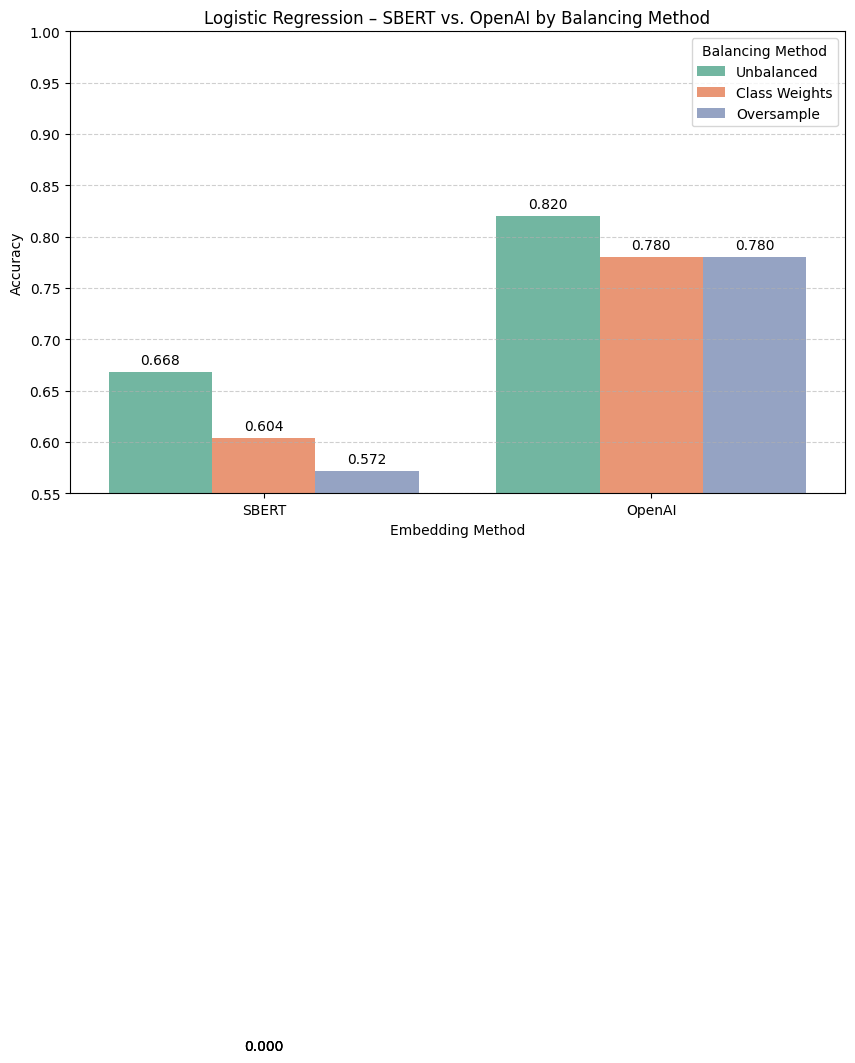

In [ ]:
# Baseline results - Logistic Regression – SBERT vs. OpenAI by Balancing Method
# Create the dataset with separate Embedding and Balancing columns
data = {
    'Embedding': ['SBERT'] * 3 + ['OpenAI'] * 3,
    'Balancing': ['Unbalanced', 'Class Weights', 'Oversample'] * 2,
    'Accuracy': [0.668, 0.604, 0.572, 0.82, 0.78, 0.78]
}

df = pd.DataFrame(data)

# Plot settings
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Embedding', y='Accuracy', hue='Balancing', palette='Set2')

plt.ylim(0.55, 1)  # Expanded to fit the full range of accuracy values
plt.title('Logistic Regression – SBERT vs. OpenAI by Balancing Method')
plt.ylabel('Accuracy')
plt.xlabel('Embedding Method')
plt.grid(axis='y', linestyle='--', alpha=0.6)

for bar in plt.gca().patches:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.005,
        f"{height:.3f}",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.legend(title='Balancing Method', loc='upper right')
plt.tight_layout()
plt.show()

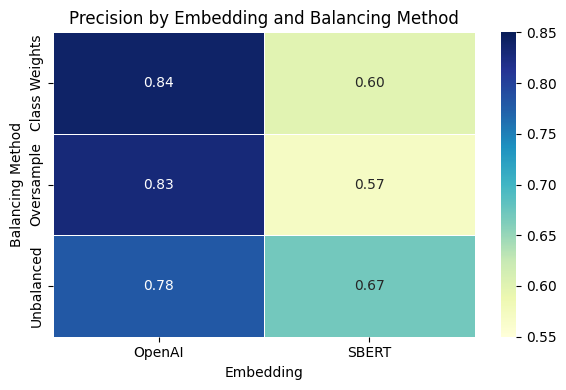

In [2]:
# Main results - Precision of Logistic Regression – SBERT vs. OpenAI by Balancing Method
data = {
    "Balancing Method": ["Class Weights", "Oversample", "Unbalanced"],
    "OpenAI": [0.84, 0.83, 0.78],
    "SBERT": [0.60, 0.57, 0.67]
}

df = pd.DataFrame(data)
df.set_index("Balancing Method", inplace=True)

plt.figure(figsize=(6, 4))
sns.heatmap(df, annot=True, fmt=".2f", cmap="YlGnBu", vmin=0.55, vmax=0.85, linewidths=0.5)

plt.title("Precision by Embedding and Balancing Method")
plt.xlabel("Embedding")
plt.ylabel("Balancing Method")
plt.tight_layout()
plt.show()


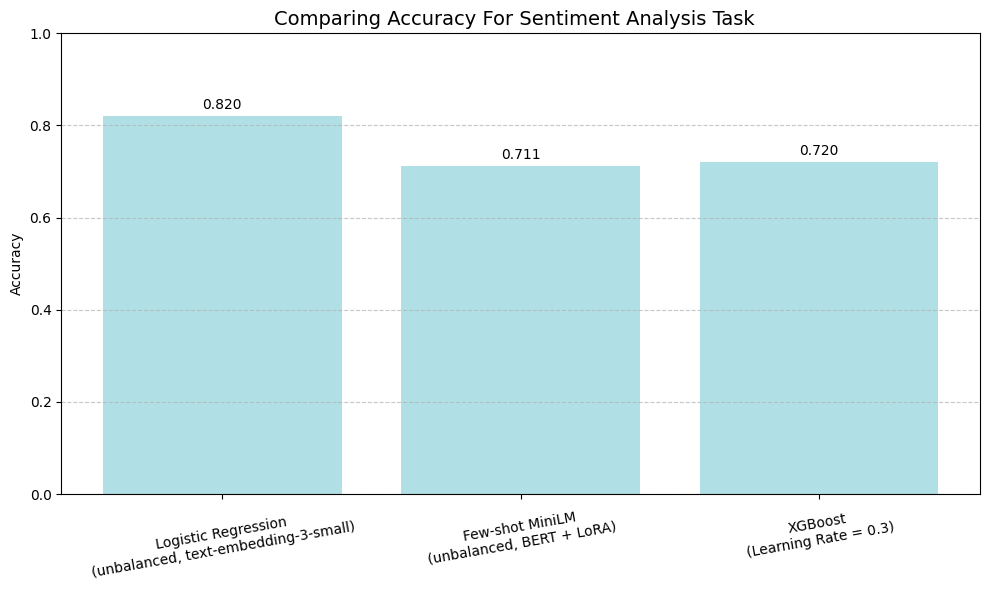

In [ ]:
# Main Results - Comparing Accuracy For Sentiment Analysis Task
models = [
    'Logistic Regression\n(unbalanced, text-embedding-3-small)',
    'Few-shot MiniLM\n(unbalanced, BERT + LoRA)',
    'XGBoost\n(Learning Rate = 0.3)'
]

accuracy_values = [0.82, 0.711, 0.72]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracy_values, color='powderblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

plt.ylim(0, 1)
plt.title('Comparing Accuracy For Sentiment Analysis Task  ', fontsize=14)
plt.ylabel('Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=10, ha='center')
plt.tight_layout()
plt.show()


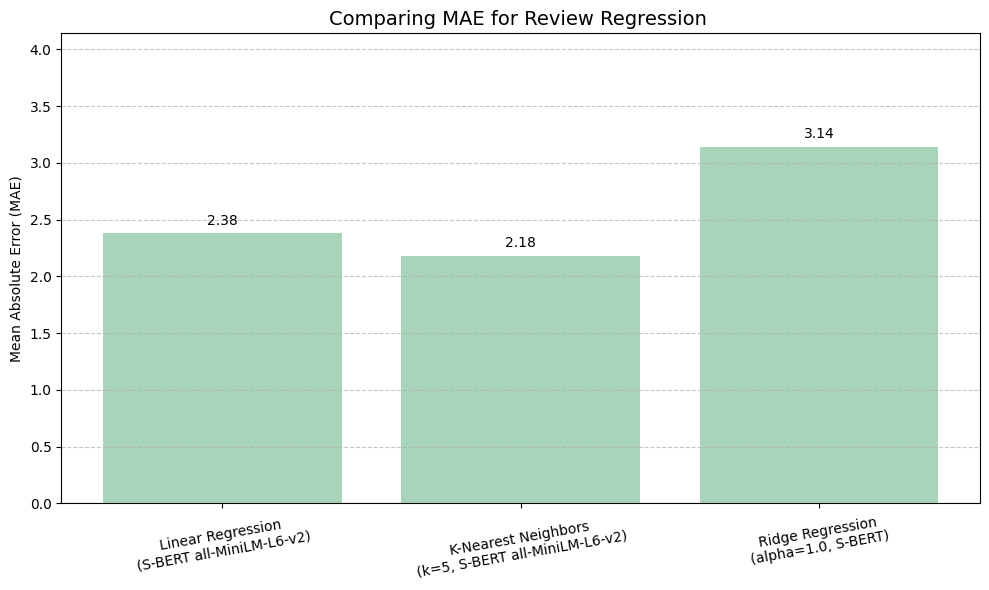

In [ ]:
# Main Results - Comparing MAE for Review Regression
models = [
    'Linear Regression\n(S-BERT all-MiniLM-L6-v2)',
    'K-Nearest Neighbors\n(k=5, S-BERT all-MiniLM-L6-v2)',
    'Ridge Regression\n(alpha=1.0, S-BERT)'
]

mae_values = [2.38, 2.18, 3.14]

pastel_green = '#A8D5BA'

plt.figure(figsize=(10, 6))
bars = plt.bar(models, mae_values, color=pastel_green)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.05, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

plt.ylim(0, max(mae_values) + 1)
plt.title('Comparing MAE for Review Regression ', fontsize=14)
plt.ylabel('Mean Absolute Error (MAE)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=10, ha='center')
plt.tight_layout()
plt.show()
